In [1]:
'''
Aim: prepare panels of figure 3 in the manuscript
Date: 27/Feb/2023
Author: Yike Xie
'''

'\nAim: prepare panels of figure 3 in the manuscript\nDate: 27/Feb/2023\nAuthor: Yike Xie\n'

optical features vs gene expression has been done in figure 2 [spectra_norm vs gene exp]

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

In [3]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    features.set_index('image', inplace=True)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)
    
    print('filter single cells')
    adata = adata[adata.obs['doublets'] != 'Yes']

    print('filter genes')
    sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

def get_correlation(adata, feas):
    
    exp = adata.X.T
    phe = adata.obs[feas].fillna(0)

    x = exp
    y = phe.values.T

    from scipy.stats import rankdata

    xw = np.zeros_like(x, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')
    yw = np.zeros_like(y, float)
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n

    corr = pd.DataFrame(
                    data=r,
                    index=adata.var_names,
                    columns=phe.columns,
                    dtype=float)

    return corr

def plot_correlation(genes, adata, fea, xlabel, path, filetype=False):
    
    import itertools
    n_genes = len(list(itertools.chain.from_iterable(genes.values())))
    colors = sns.color_palette('tab10', n_genes)
    colors = [colors[: len(genes['positive'])], colors[len(genes['positive']):]]

    fig, axs = plt.subplots(2, 1, figsize=(4, 6), dpi=300)
    rcParams['pdf.fonttype'] = 42
    rcParams['font.sans-serif'] = "Arial"
    
    for j, (ax, genes) in enumerate(zip(axs, [genes['positive'], genes['negative']])):
        for ig, gene in enumerate(genes):
            x = adata.obs[fea]
            y = adata[:, gene].X + 0.1
            idx = np.argsort(x)
            ax.scatter(
                x[idx], y[idx], alpha=0.8, label=gene, lw=2, color=colors[j][ig], s=10, 
            )
        ax.legend(fontsize=8, bbox_to_anchor=(1, 1))
        ax.set_xlabel(xlabel)
        ax.set_ylabel('Gene exp [cpm]')
        ax.set_yscale('log')
#         ax.set_xscale('log')
        
    axs[0].set_title('Positive correlation')
    axs[1].set_title('Negative correlation')
    fig.tight_layout()

    if filetype is not False:
        plt.savefig(save_figures + fea + filetype)
    
    return {'fig': fig, 'axs': axs}

def plot_bins(adata, fea, bin_n, gene, cmap, filetype, path=False):
    area_order = adata.obs[fea].sort_values().index
    exp = adata[area_order, gene].X
    exp = pd.DataFrame(exp[:,0], index=area_order, columns=['Gene exp [cpm]'])

    exp['order'] = '0'
    for i in range(bin_n):
        n = int(exp.shape[0] / bin_n)
        idx = np.arange(n) + n * i
        exp.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    fig, ax = plt.subplots(figsize=[2, 3])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    med = [exp[exp['order'] == 'Group {}'.format(str(i + 1))]['Gene exp [cpm]'].median()
           for i in range(bin_n)]
    alpha = [0.2 + 0.6 * i/max(med) for i in med]
    cmap = mpl.cm.get_cmap(cmap)
    palette = [cmap(i) for i in alpha]

    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
    sns.boxplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, **PROPS)
    sns.stripplot(data=exp, x='order', y='Gene exp [cpm]', palette=palette, edgecolor='white', linewidth=1, size=3)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_xlabel('{}: smallest → largest'.format([fea.title(), fea][fea.isupper()]))
    ax.set_title(gene)
    ax.set_yscale('log')

    if path is not False:
        fig.savefig(os.path.join(path, f'{fea}_{gene}{filetype}'), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'ax': ax}

In [4]:
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/segmentation/background_subtraction/bkg_sub_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/20220201_NextSeq/gene_filter.h5ad'
adata = sig_dataset(feas_fn, data_fn)
adata.obs['spectra_norm'] = np.array(adata.obs['spectra'].tolist()).mean(axis=1) / adata.obs['area']

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/hyperspectral_images/correlate_features/PCA_gene/'

load features
load dataset
filter single cells


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
Trying to set attribute `.var` of view, copying.


filter genes
Add features to adata


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


## PCA on 15 pectras and select components with high variances

In [5]:
df = pd.DataFrame(index=adata.obs_names, columns=adata.obs['wavelengths'].iloc[0])
for i in df.index:
    df.loc[i] = adata.obs['spectra'].loc[i] / adata.obs['area'].loc[i]
    
from sklearn.decomposition import PCA
X = df.values
pca = PCA()
X_r = pca.fit(X).transform(X)

if False:
    PCA_df = pd.DataFrame(X_r, index=df.index, columns=['PC{}'.format(str(i + 1)) for i in range(15)])
    PCA_df.loc['exp_var'] = pca.explained_variance_ratio_
    PCA_df.to_csv(save_figures + 'PCA_15PC.tsv', sep='\t')
    
    components = pd.DataFrame(pca.components_, index=['PC{}'.format(str(i)) for i in range(1, 16)],
             columns=adata.obs['wavelengths'].iloc[0])
    components.to_csv(save_figures + 'PCA_components.tsv', sep='\t')

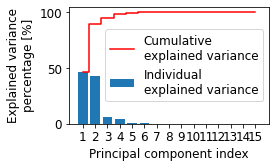

In [23]:
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

fig, ax = plt.subplots(figsize=[4, 2.5])
rcParams['pdf.fonttype'] = 42
rcParams['font.size'] = 12
ax.bar(range(1, len(exp_var) + 1), exp_var, align='center',
        label='Individual\nexplained variance')
ax.step(range(1, len(exp_var) + 1), cum_exp_var, where='mid',
         label='Cumulative\nexplained variance', color='red')

ax.set_ylabel('Explained variance\npercentage [%]')
ax.set_xlabel('Principal component index')
ax.set_xticks(ticks=range(1, len(exp_var) + 1))
ax.legend(loc='best', fontsize=12)
fig.tight_layout()
fig.savefig(save_figures + 'PCA_exp_vars.pdf', dpi=300, bbox_inches='tight')
fig.savefig(save_figures + 'PCA_exp_vars.png', dpi=300, bbox_inches='tight')

In [5]:
components = pd.read_csv(save_figures + 'PCA_components.tsv', sep='\t', index_col=0)

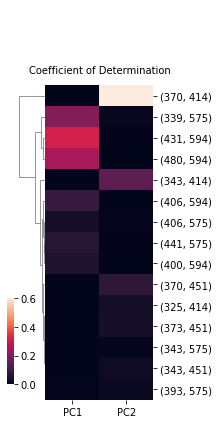

In [53]:
# plot coefficient of correlation of PC1 and PC2
rcParams['pdf.fonttype'] = 42
g = sns.clustermap(pow(components.loc[['PC1', 'PC2']], 2).T, col_cluster=False, vmin=0, vmax=0.6, 
                   cbar_pos=[0, 0.1, 0.03, 0.2],
              figsize=[3, 6])
g.fig.text(0.1, 0.82, 'Coefficient of Determination')
g.savefig(save_figures + 'square_R.pdf', dpi=150, bbox_inches='tight')

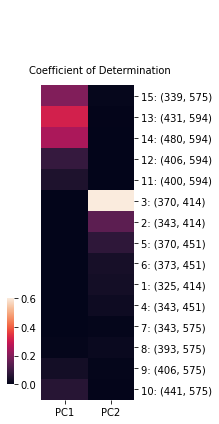

In [23]:
wl_index = ['(339, 575)', '(431, 594)', '(480, 594)', '(406, 594)', '(400, 594)', # PC1
            '(370, 414)',  '(343, 414)', '(370, 451)','(373, 451)', 
            '(325, 414)','(343, 451)', '(343, 575)', '(393, 575)', '(406, 575)', '(441, 575)',
            ]
index = [str(list(components.columns).index(i) + 1) + ': ' + i  for i in wl_index]
rcParams['pdf.fonttype'] = 42
df = pow(components.loc[['PC1', 'PC2']], 2).T.loc[wl_index]
df.index = index
g = sns.clustermap(df, col_cluster=False, row_cluster=False,
                vmin=0, vmax=0.6, cbar_pos=[0, 0.1, 0.03, 0.2],
                figsize=[3, 6])
g.fig.text(0.1, 0.82, 'Coefficient of Determination')
g.savefig(save_figures + 'square_R2.pdf', dpi=150, bbox_inches='tight')



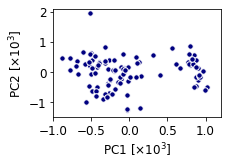

In [219]:
# plot a scatter plot with PC1 and PC2
fig, ax = plt.subplots(figsize=[3, 2])
rcParams['font.size'] = 12
ax.scatter(X_r[:, 0]/10e3, X_r[:, 1]/10e3, edgecolor='white', s=30, color='navy')
ax.set(xlabel='PC1 [×$10^3$]', ylabel='PC2 [×$10^3$]', #  [×$10^3$]
       xticks=[-1. , -0.5,  0. ,  0.5,  1. ,  1.5], 
       yticks=[-2., -1.,  0.,  1.,  2.,  3.],
       xlim=[-1, 1.2], ylim=[-1.5, 2.1])

fig.savefig(save_figures + 'PC2_PC1.pdf', dpi=300, bbox_inches='tight')

## correlation between PC1, PC2 with gene expression

In [145]:
# compute the correlations between PC1, PC2 and gene expression
feas = ['PC1', 'PC2']
# add PC1 and PC2 to dataset
adata.obs['PC1'] = PCA_df[: -1].loc[adata.obs_names]['PC1']
adata.obs['PC2'] = PCA_df[: -1].loc[adata.obs_names]['PC2']

corr = get_correlation(adata, feas)
corr.to_csv(save_figures + 'correlation_PCA.tsv', sep='\t')

In [24]:
corr = pd.read_csv(save_figures + 'correlation_PCA.tsv', sep='\t', index_col=0)

# percentage of cells expressing this gene
pct = 0.8
gene_pct = pd.Series((adata.X > 0).sum(axis=0) / adata.obs.shape[0], index=adata.var_names)
high_pct = gene_pct[gene_pct >= pct].index

# filter genes expressed by more than 80% cells
df = corr.loc[high_pct]

## scatterplot and barplot of genes

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


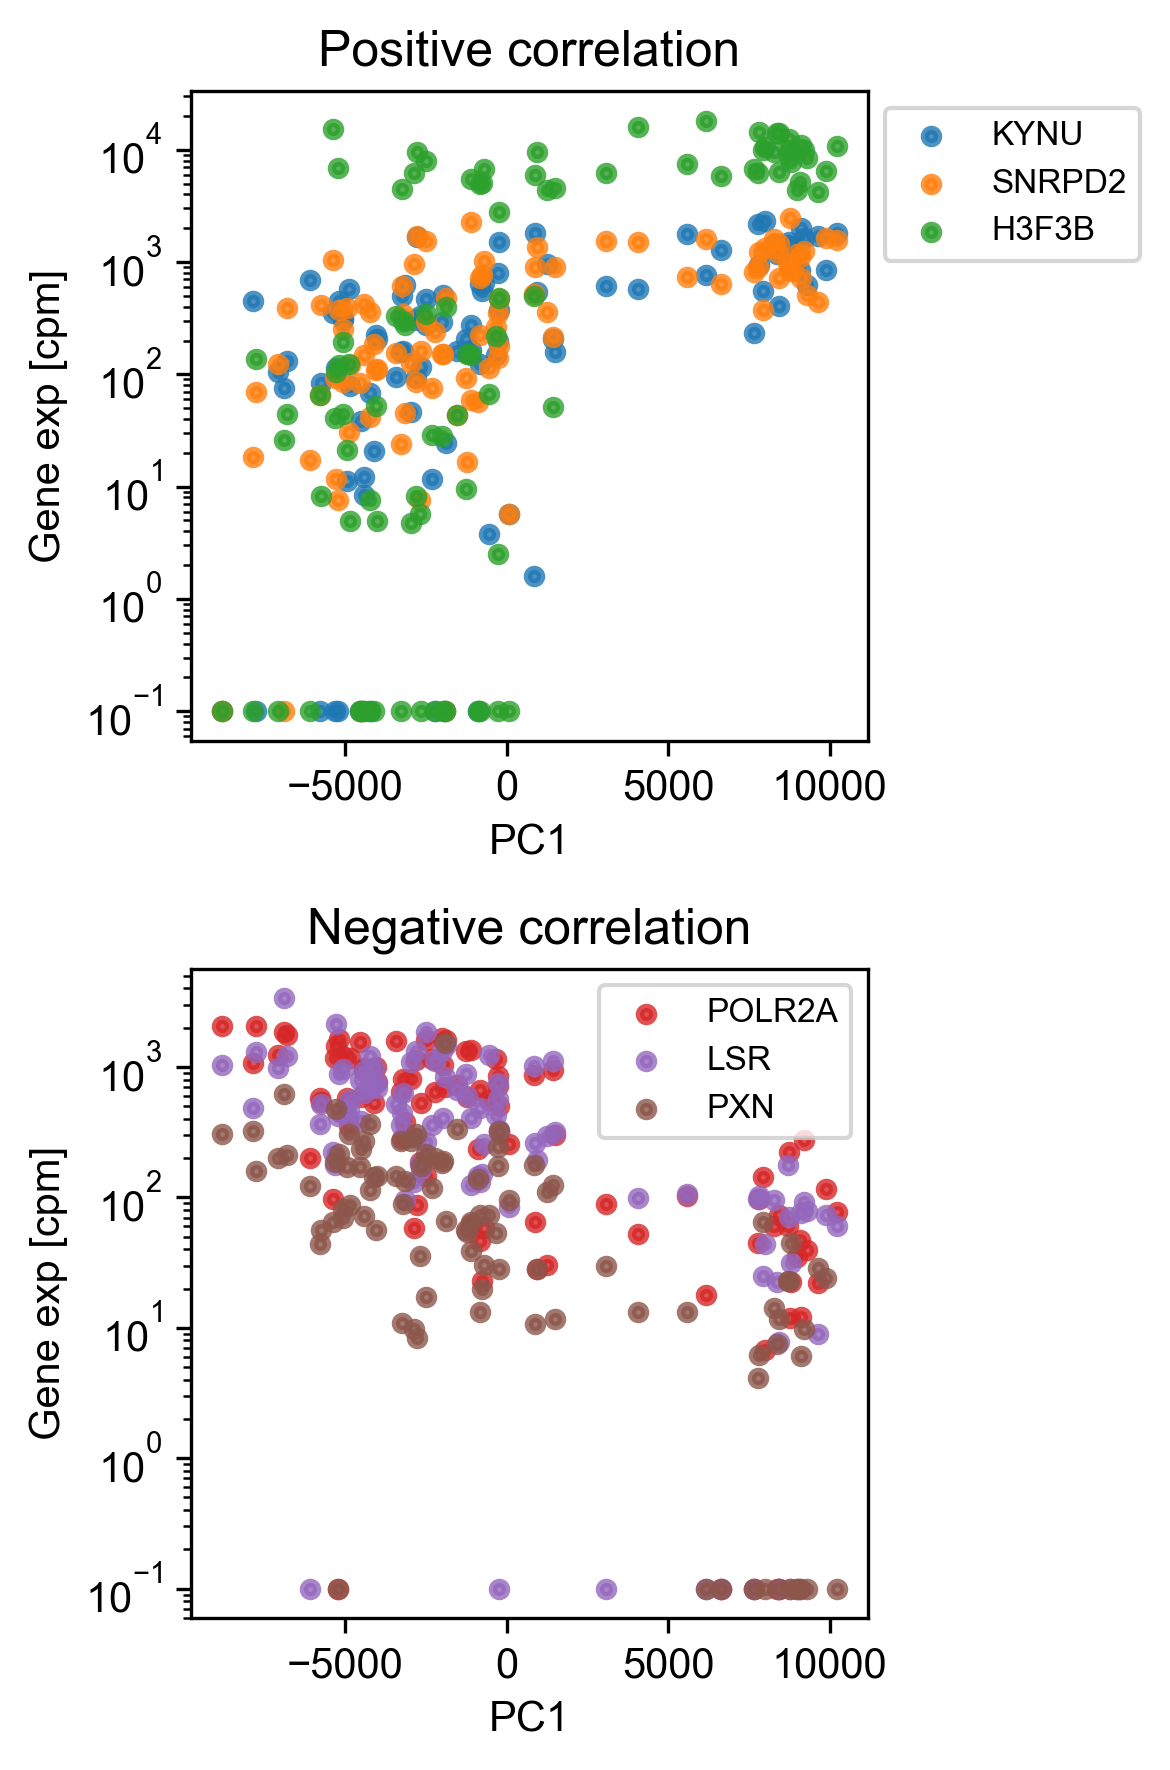

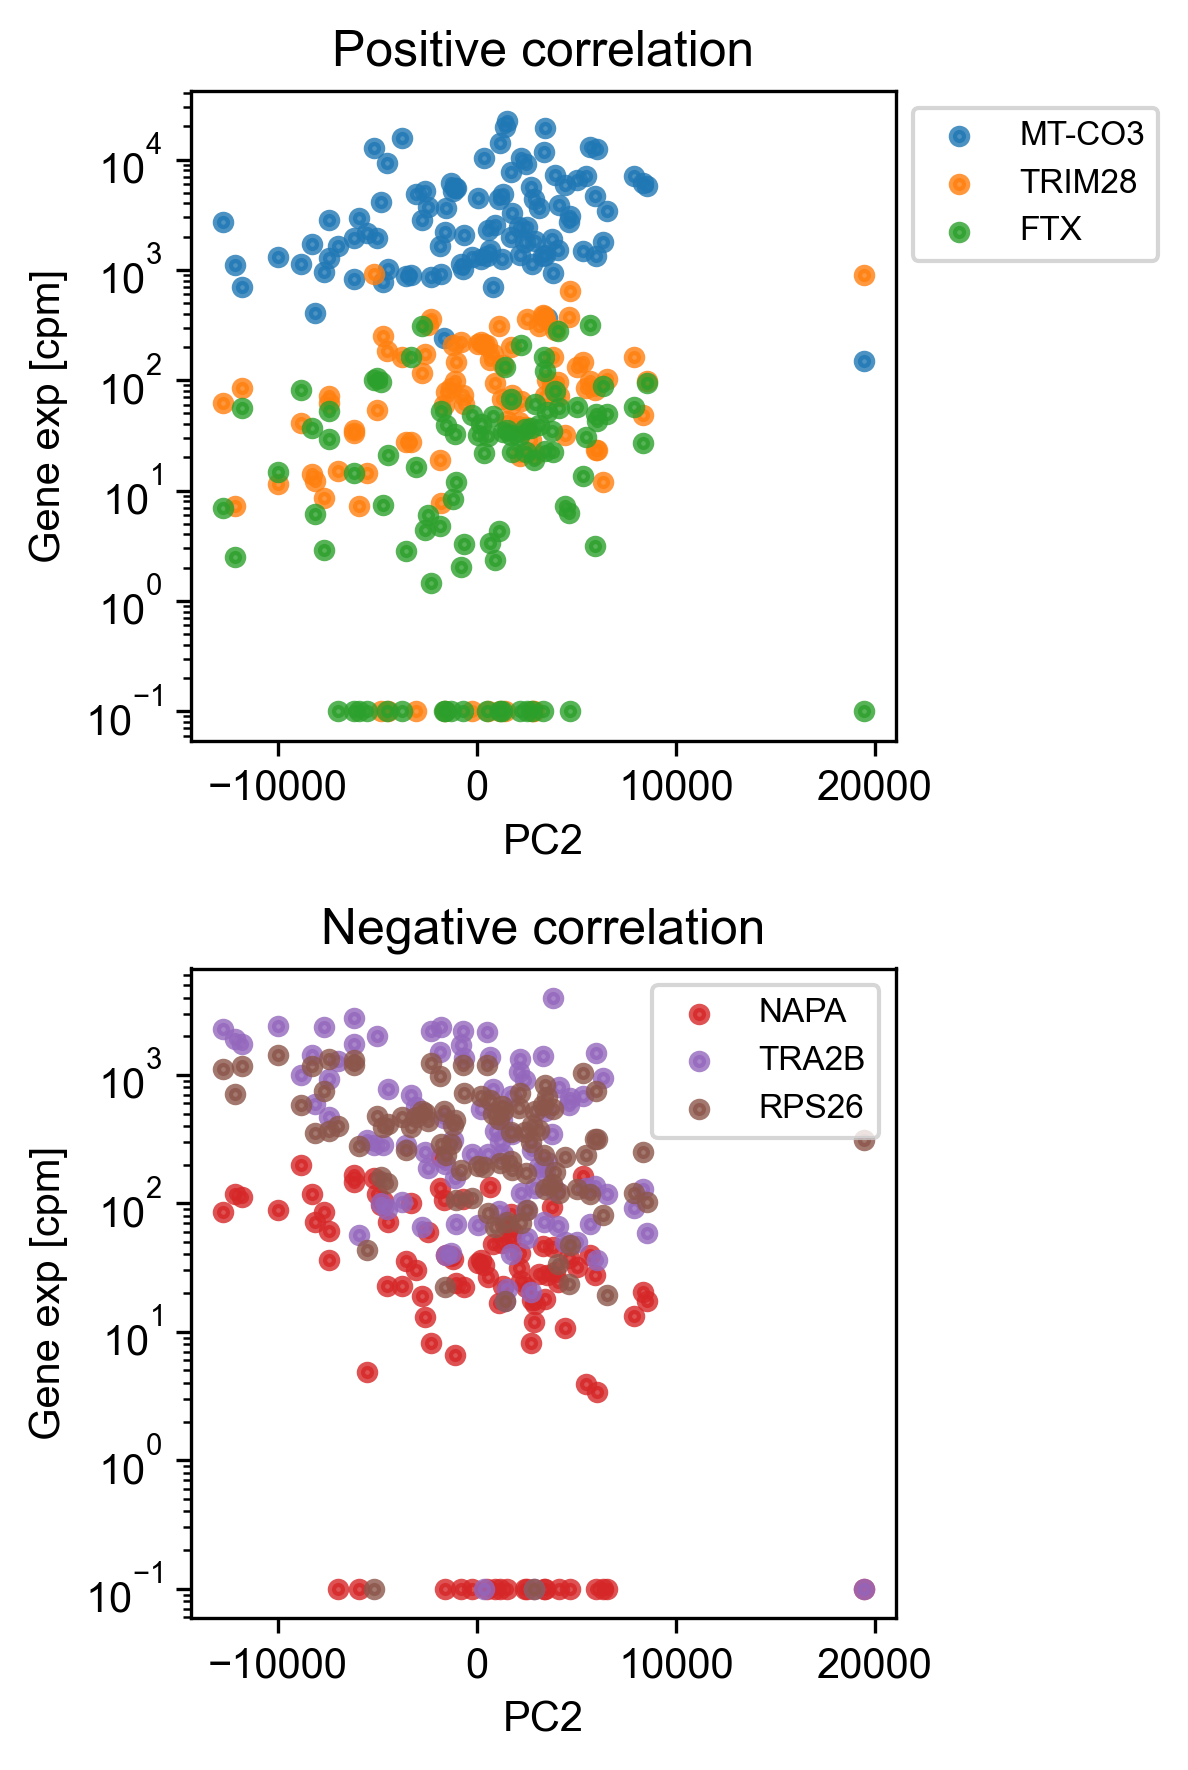

In [171]:
# plot the 3 genes with highest positive or negative correlations
feas = ['PC1', 'PC2']
xlabels = ['PC1', 'PC2']

for fea, xlabel in zip(feas, xlabels):
    pos_genes = corr.loc[high_pct].nlargest(3, fea).index
    neg_genes = corr.loc[high_pct].nsmallest(3, fea).index

    path = save_figures
    filetype = '.png' 
    genes = {
        'positive': pos_genes,
        'negative': neg_genes,
    }
    plot_correlation(genes, adata, fea, xlabel, path, filetype='.pdf')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

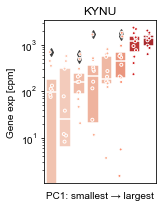

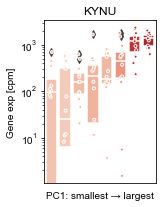

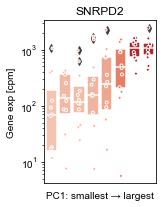

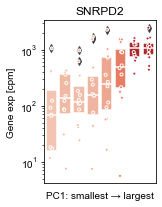

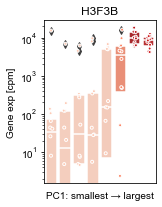

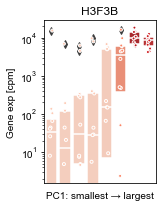

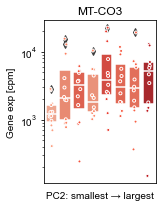

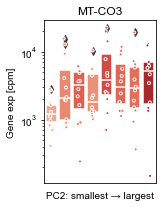

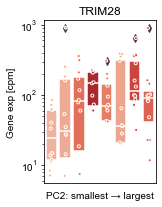

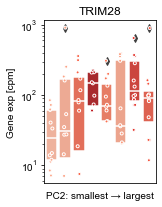

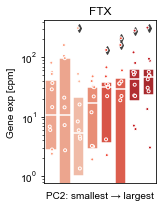

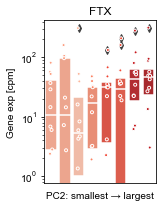

In [181]:
feas = ['PC1', 'PC2']

for fea in feas:
    pos = corr.loc[high_pct].nlargest(3, fea).index

    for gene in pos:
        cmap = 'Reds'
        bin_n = 8
        path = save_figures

        plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', path)
        plot_bins(adata, fea, bin_n, gene, cmap, '.png', path)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

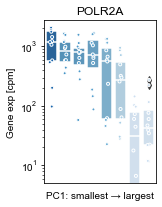

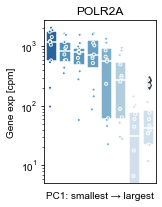

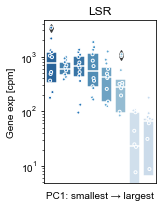

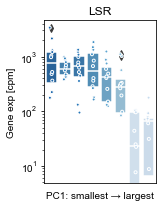

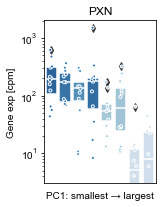

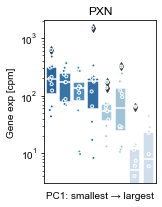

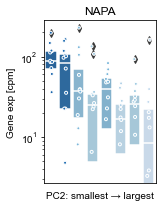

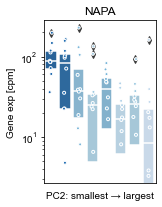

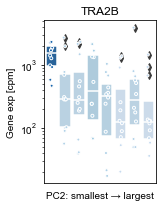

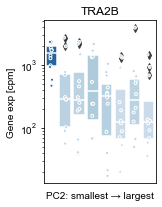

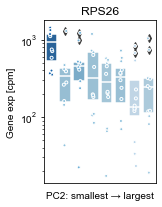

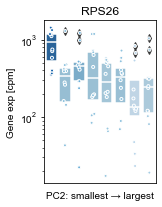

In [182]:
feas = ['PC1', 'PC2']

for fea in feas:
    negs = corr.loc[high_pct].nsmallest(3, fea).index

    for gene in negs:
        cmap = 'Blues'
        bin_n = 8
        path = save_figures

        plot_bins(adata, fea, bin_n, gene, cmap, '.pdf', path)
        plot_bins(adata, fea, bin_n, gene, cmap, '.png', path)

### genes filtered via coefficients of correlation

In [116]:
df['r'] = np.sqrt(df['PC1'] ** 2 + df['PC2'] ** 2)
r = df['r'].quantile(0.95)
df['color'] = 'gray'
df.loc[df[(df['r'] >= df['r'].quantile(0.95)) &
          (df['PC1'] > 0) & (df['PC2'] > 0)].index, 'color'] = 'orange'
df.loc[df[(df['r'] >= df['r'].quantile(0.95)) &
          (df['PC1'] < 0) & (df['PC2'] < 0)].index, 'color'] = 'navy'

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(


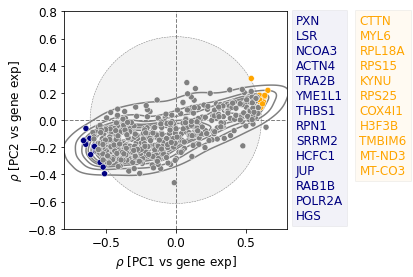

In [218]:
fig, ax = plt.subplots(figsize=[4, 4])
sns.scatterplot(data=df, x='PC1', y='PC2', hue='color', palette=['gray', 'orange', 'navy'], 
                hue_order=['gray', 'orange', 'navy'], ax=ax)
sns.kdeplot(data=df, x='PC1', y='PC2', fill=False, zorder=0.5, color='gray', lw=0.5)
ax.set_xlim(-0.8, 0.8)
ax.set_ylim(-0.8, 0.8)
ax.axvline(0, color='gray', zorder=0.5, ls='--', lw=1)
ax.axhline(0, color='gray', zorder=0.5, ls='--', lw=1)
rgb = list(mpl.colors.to_rgba('grey'))[:-1]
circle = plt.Circle((0, 0), r, edgecolor='gray', facecolor=tuple(rgb + [0.1]), ls='--', lw=0.5, zorder=0.5)
ax.add_artist(circle)
ax.get_legend().remove()
ax.set(xlabel=r'$\rho$ [PC1 vs gene exp]', ylabel=r'$\rho$ [PC2 vs gene exp]')

fig.text(1.15, 0.315, '\n'.join(df[df['color'] == 'orange'].index), 
         bbox=dict(facecolor='orange', alpha=0.05), color='orange')

fig.text(0.93, 0.16, '\n'.join(df[df['color'] == 'navy'].index), 
         bbox=dict(facecolor='navy', alpha=0.05), color='navy')
fig.savefig(save_figures + 'scatter_PC12.pdf', dpi=150, bbox_inches='tight')
fig.savefig(save_figures + 'scatter_PC12.png', dpi=150, bbox_inches='tight')

In [172]:
# plot eclipse
threshold = 0.013
xr = df['PC1'][df['PC1'] > 0].quantile(1 - threshold)
xl = df['PC1'][df['PC1'] < 0].quantile(threshold)
x0 = (xr + xl) / 2 # x-position of the center

yr = df['PC2'][df['PC2'] > 0].quantile(1 - threshold)
yl = df['PC2'][df['PC2'] < 0].quantile(threshold)
y0 = (yr + yl) / 2 # y-position of the center

a = (abs(xr) + abs(xl))  # radius on the x-axis
b = (abs(yr) + abs(yl))  # radius on the y-axis

x, y = df[['PC1', 'PC2']].values.T
theta = np.arctan(((x -x0) * (y - y0)).mean()/((x - x0) * (x - x0)).mean()) / np.pi * 180 # Ordinary least squares

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'lw'
  cset = contour_func(


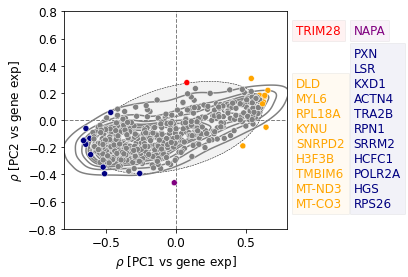

In [191]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=[4, 4])
rgb = list(mpl.colors.to_rgba('grey'))[:-1]
ellipse = Ellipse(xy=(x0, y0), angle=theta, width=a, height=b, edgecolor='k',
                  facecolor=tuple(rgb + [0.1]), ls='--', lw=0.5, zorder=0.5)
ax.add_patch(ellipse)
cos_angle = np.cos(np.radians(180. - theta))
sin_angle = np.sin(np.radians(180. - theta))
xc = x - x0
yc = y - y0
xct = xc * cos_angle - yc * sin_angle
yct = xc * sin_angle + yc * cos_angle 
rad_cc = (xct**2/(a/2.)**2) + (yct**2/(b/2.)**2)
df['ellipse'] = 'gray'
# colors_array[np.where(rad_cc >= 1)[0]] = 'red'
orange_idx = list(set(np.where(rad_cc >= 1)[0]) & set(np.where(df['PC1'] >= 0.25)[0]) )
navy_idx = list(set(np.where(rad_cc >= 1)[0]) & set(np.where(df['PC1'] <= -0.25)[0]))
purple_idx = list(set(np.where(rad_cc >= 1)[0]) & 
     set(np.where((-0.1 > df['PC2']) & (-0.25 < df['PC1']) & (0.25 > df['PC1']))[0]))
red_idx = list(set(np.where(rad_cc >= 1)[0]) & 
     set(np.where((0.1 < df['PC2']) & (-0.25 < df['PC1']) & (0.25 > df['PC1']))[0]))
df.loc[df.index[orange_idx], 'ellipse'] = 'orange'
df.loc[df.index[navy_idx], 'ellipse'] = 'navy'
df.loc[df.index[purple_idx], 'ellipse'] = 'purple'
df.loc[df.index[red_idx], 'ellipse'] = 'red'

sns.scatterplot(data=df, x='PC1', y='PC2', ax=ax, hue='ellipse', 
                palette=['gray', 'orange', 'navy', 'purple', 'red'], 
                hue_order=['gray', 'orange', 'navy', 'purple', 'red'], )
sns.kdeplot(data=df, x='PC1', y='PC2', fill=False, zorder=0.5, color='gray', lw=0.5)
ax.set_xlim(-0.8, 0.8)
ax.set_ylim(-0.8, 0.8)
ax.axvline(0, color='gray', zorder=0.5, ls='--', lw=1)
ax.axhline(0, color='gray', zorder=0.5, ls='--', lw=1)

ax.set(xlabel=r'$\rho$ [PC1 vs gene exp]', ylabel=r'$\rho$ [PC2 vs gene exp]')
ax.legend().remove()

fig.text(0.93, 0.2, '\n'.join(df[df['ellipse'] == 'orange'].index), 
         bbox=dict(facecolor='orange', alpha=0.05), color='orange')
fig.text(0.93, 0.8, '\n'.join(df[df['ellipse'] == 'red'].index), 
         bbox=dict(facecolor='red', alpha=0.05), color='red')

fig.text(1.13, 0.2, '\n'.join(df[df['ellipse'] == 'navy'].index), 
         bbox=dict(facecolor='navy', alpha=0.05), color='navy')
fig.text(1.13, 0.8, '\n'.join(df[df['ellipse'] == 'purple'].index), 
         bbox=dict(facecolor='purple', alpha=0.05), color='purple')

fig.savefig(save_figures + 'scatter_PC12_new.pdf', dpi=150, bbox_inches='tight')
fig.savefig(save_figures + 'scatter_PC12_new.png', dpi=150, bbox_inches='tight')

In [197]:
df.loc[df[df['ellipse'] == 'navy'].index]

,PC1,PC2,eclipse,ellipse
gene_name,,,,
PXN,-0.646535,-0.170556,red,navy
LSR,-0.657225,-0.146386,red,navy
KXD1,-0.466212,0.056431,gray,navy
ACTN4,-0.645281,-0.178342,red,navy
TRA2B,-0.510682,-0.394769,red,navy
RPN1,-0.520989,-0.346010,red,navy
SRRM2,-0.644155,-0.061573,red,navy
HCFC1,-0.616019,-0.133357,gray,navy
POLR2A,-0.661602,-0.151055,red,navy


In [153]:
# define a scatterplot to show genes in the UMAP created by PC1 and PC2
def PCA_plot(df, adata, gene, path, filetype=False,):
    PCA_gene = df[['PC1', 'PC2']][:-1].copy()
    PCA_gene['Gene exp'] = np.log10(adata[PCA_gene.index, gene].X[:, 0] + 0.1)
    PCA_gene['PC1'] = PCA_gene['PC1']/10e3
    PCA_gene['PC2'] = PCA_gene['PC2']/10e3
    vmin = -1
    vmax = round(PCA_gene['Gene exp'].max())
    
    fig, ax = plt.subplots(figsize=[3, 2])
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 12
    cmap = plt.cm.get_cmap('viridis')
    colors = [cmap((min(vmax, av) - vmin) / (vmax - vmin)) for av in PCA_gene['Gene exp']]
    sns.scatterplot(data=PCA_gene, x='PC1', y='PC2', s=30, c=colors)
    ax.set(xlabel='PC1 [×$10^3$]', ylabel='PC2 [×$10^3$]',
           xticks=[-1. , -0.5,  0. ,  0.5,  1. ,  1.5], 
           yticks=[-2., -1.,  0.,  1.,  2.,  3.],
           xlim=[-1, 1.2], ylim=[-1.5, 2.1])
    ax.set_title(gene)

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax) 
    position = fig.add_axes([0.95, 0.1, 0.05, 0.8])
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                 cax=position, ax=ax, label='Gene exp [cpm]')
    cbar.ax.set_yticks([np.log10(i + 0.1) for i in [10**i for i in range(vmin, vmax+1)]])
    cbar.ax.set_yticklabels(['0', '1', '10'] + ['$10^{}$'.format(str(i)) for i in range(2, vmax+1)])
    
    if filetype is not False:
        fig.savefig(os.path.join(path, 'PCA_plot_{}'.format(gene) + filetype), dpi=150, bbox_inches='tight')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categor

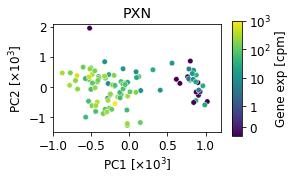

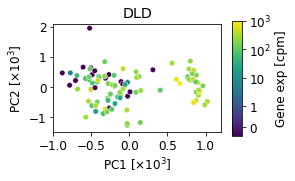

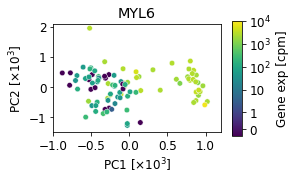

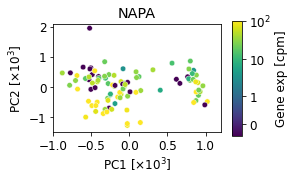

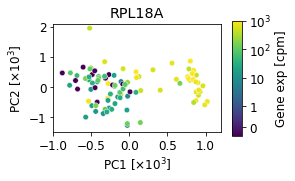

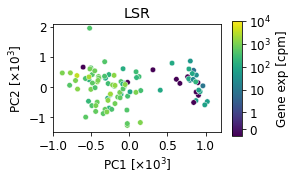

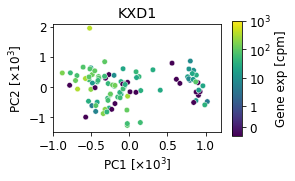

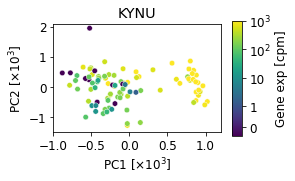

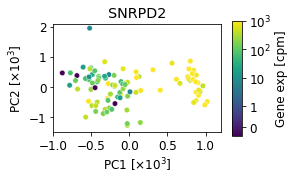

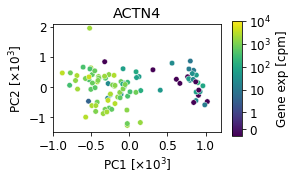

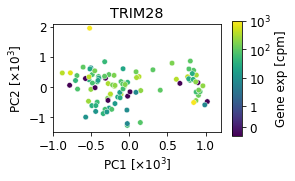

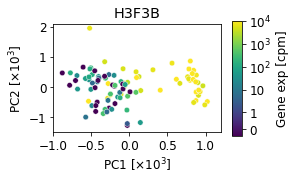

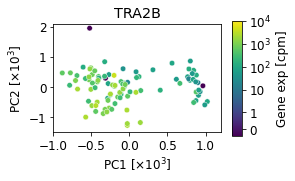

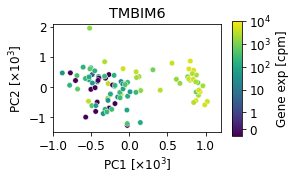

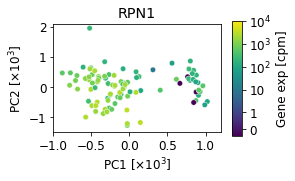

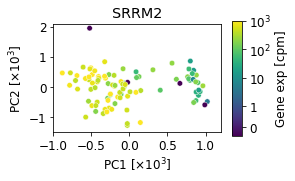

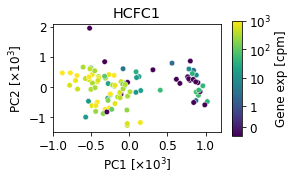

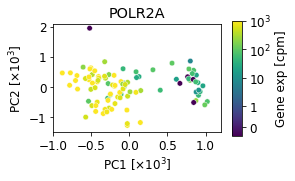

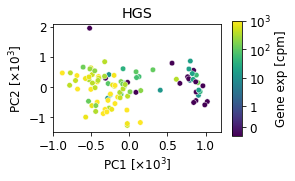

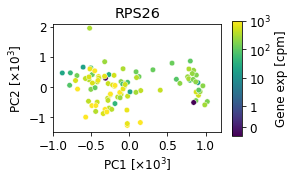

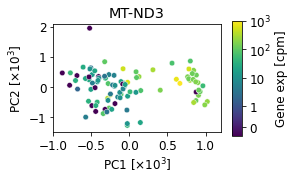

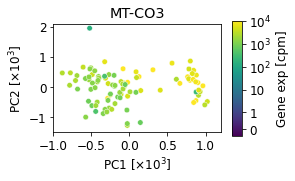

In [192]:
PCA_df = pd.read_csv(save_figures + 'PCA_15PC.tsv', sep='\t', index_col=0)

for gene in df[df['ellipse'] != 'gray'].index:
    PCA_plot(PCA_df, adata, gene, save_figures +'/PCA_plot/new/', filetype='.pdf')

### genes filtered via kde density

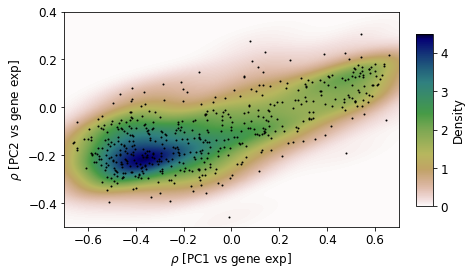

In [385]:
import scipy.stats as stats
# xmin = df['PC1'].min()
# xmax = df['PC1'].max()
# ymin = df['PC2'].min()
# ymax = df['PC2'].max()
xmin, xmax = -0.7, 0.7
ymin, ymax = -0.5, 0.4

X, Y = np.mgrid[xmin:xmax:1000j, ymin:ymax:1000j]
positions = np.vstack([X.ravel(), Y.ravel()])
values = np.vstack([df['PC1'], df['PC2']])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions), X.shape)

# plot
fig, ax = plt.subplots()
rcParams['pdf.fonttype'] = 42
cmap = plt.cm.gist_earth_r
ax.imshow(np.rot90(Z), cmap=cmap, vmin=4.5e-16, vmax=4.5,
          extent=[xmin, xmax, ymin, ymax])
ax.plot(df['PC1'], df['PC2'], 'k.', markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
ax.set(xlabel=r'$\rho$ [PC1 vs gene exp]', ylabel=r'$\rho$ [PC2 vs gene exp]')

norm = mpl.colors.Normalize(vmin=4.5e-16, vmax=4.5) 
position = fig.add_axes([0.94, 0.2, 0.04, 0.6])
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
             cax=position, ax=ax, label='Density')

fig.savefig(save_figures + 'kde_plot.pdf', dpi=150, bbox_inches='tight')
fig.savefig(save_figures + 'kde_plot.png', dpi=150, bbox_inches='tight')

In [416]:
sig_genes = []
mask = (np.rot90(Z) < 0.0015)
for gene in high_pct:
    gene_x = round((df.loc[gene]['PC1'] - xmin) / (xmax - xmin) * 1000)
    gene_y = round((df.loc[gene]['PC2'] - ymin) / (ymax - ymin) * 1000)
    if mask[gene_x, gene_y]:
        sig_genes.append(gene)

In [417]:
len(sig_genes)

89

### gene correlation vs fraction of cells expressing the gene

In [424]:
corr['Frac'] = 100 * (adata[:, corr.index].X > 0).sum(axis=0) / 96

In [481]:
def save_PC_frac_genes(corr, PC, threshold):
    res = []

    for f in corr['Frac'].sort_values().unique():
        df_f = corr[(corr['Frac'] == f)]
        hmax = df_f[PC].quantile(threshold)
        hmin = df_f[PC].quantile(1 - threshold)

        ups = df_f[df_f[PC] >= hmax].index
        downs = df_f[df_f[PC] <= hmin].index

        feas = {
            'frac': f,
            'up_genes': ups, 
            'down_genes': downs, 
            'hmax': hmax, 
            'hmin': hmin,
        }
        res.append(feas)

    res = pd.DataFrame(res)
    
    return res

In [490]:
threshold = 0.995
PC = 'PC1'

res = save_PC_frac_genes(corr, PC, threshold)
with open(save_figures + '{}_genes_{}.pickle'.format(PC, str(threshold)), 'wb') as handle:
    pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [483]:
threshold = 0.995
PC = 'PC2'

res = save_PC_frac_genes(corr, PC, threshold)
with open(save_figures + '{}_genes_{}.pickle'.format(PC, str(threshold)), 'wb') as handle:
    pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)

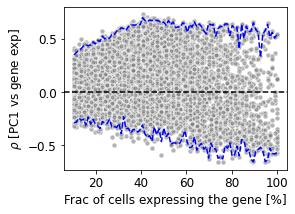

In [491]:
fig, ax = plt.subplots(figsize=[4, 3])
ax.scatter(corr['Frac'], corr['PC1'], color='gray', edgecolor='white', alpha=0.6, s=25)
ax.axhline(0, c='k', ls='--')
ax.plot(res['frac'], res['hmax'], c='blue', ls='--')
ax.plot(res['frac'], res['hmin'], c='blue', ls='--')
ax.set(xlabel='Frac of cells expressing the gene [%]', ylabel=r'$\rho$ [PC1 vs gene exp]')

fig.savefig(save_figures + 'PC1_vs_frac.png', dpi=150, bbox_inches='tight')

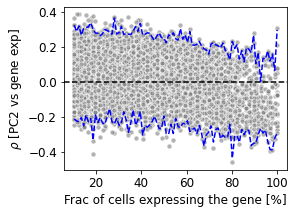

In [488]:
fig, ax = plt.subplots(figsize=[4, 3])
ax.scatter(corr['Frac'], corr['PC2'], color='gray', edgecolor='white', alpha=0.6, s=25)
ax.axhline(0, c='k', ls='--')
ax.plot(res['frac'], res['hmax'], c='blue', ls='--')
ax.plot(res['frac'], res['hmin'], c='blue', ls='--')
ax.set(xlabel='Frac of cells expressing the gene [%]', ylabel=r'$\rho$ [PC2 vs gene exp]')

fig.savefig(save_figures + 'PC12_vs_frac.png', dpi=150, bbox_inches='tight')